# Final project for <i>How to win a Data Science competition</i>
<br>In this final project we'll be predicting itens sale from a company.
<br>The full description from this problem can be checked here: https://www.kaggle.com/c/competitive-data-science-predict-future-sales. The course can be acessed to Coursera plataform in <i>"How to win a Data Science competition"</i>
<br>This is the second and final notebook for this problem, for reference and understand what we did please check <b> Data Preparation and feature engineering </b>first.
<br>
<br> Ps: Notice that are two different "tests":
1. x_test is actually a "validation" dataset where we check for the performance in another population and diagnosis the model as a stable. 
2. The "test" dataset is the one that we're scoring without being able to check for performane and then sending to kaggle!

# Summary

* In this notebook only LGBM will be used for a very simple reason: the dataset is just huge and my hardware just can't run on XGB/CAT library. We'll also test some other models but it'll be focused on LGBM.
My strategy will be the following:
1. First of all check for "vanila" performance (no parameter tuning) for my *own* parameters (that I generally use while modeling). I'll be doing this for standard gbst and dart in LGBM library. And then:

* Extremely overfitting the data: I want to check the best rmse (or l2) that we can achieve first
<br><b>OR</b> if the model overfits for training data:
* <i>Regulating</i> our data: Trying to adjust parameters to decrease overfit but also decrease learning in the process.

In [1]:
import lightgbm as lgbm
import pandas as pd
import numpy as np
train_final=pd.read_csv('raw_df.csv')
x_train=train_final[(train_final.date_block_num>12)&(train_final.date_block_num<32)]
x_test=train_final[(train_final.date_block_num>=32)&(train_final.date_block_num<34)]
test=train_final[train_final.date_block_num==34]
#test=pd.read_csv('test_final.csv')
#test.drop('Unnamed: 0', axis=1, inplace=True)
#test.fillna(0, inplace=True)

In [2]:
x_train.drop('Unnamed: 0', axis=1, inplace=True)
x_test.drop('Unnamed: 0', axis=1, inplace=True)

x_train.fillna(0, inplace=True)
x_test.fillna(0, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [5]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=50, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgbm.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgbm.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgbm.train(lgb_params,
                     xgtrain,
                     valid_sets=[xgtrain, xgvalid],
                     valid_names=['train','valid'],
                     evals_result=evals_results,
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10,
                     feval=feval)

    n_estimators = bst1.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics+":", evals_results['valid'][metrics][n_estimators-1])

    return bst1

In [4]:
x_train.columns.values

array(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'ID',
       'revenue_last_1month', 'revenue_last_2month',
       'revenue_last_3month', 'item_price_last_1month',
       'item_cnt_month_last_1month', 'item_cnt_month_last_2month',
       'item_cnt_month_last_3month', 'last_revenue_compared_2_months',
       'last_revenue_avg_2_months', 'last_month_compared_revenueavg',
       'last_revenue_compared_3_months', 'last_revenue_avg_3_months',
       'last_item_cnt_month_compared_2_months',
       'last_item_cnt_month_avg_2_months',
       'last_month_compared_item_cnt_monthavg',
       'last_item_cnt_month_compared_3_months',
       'last_item_cnt_month_avg_3_months', 'shop_item_sold_before',
       'item_is_featured_global', 'shop_is_opening',
       'price_dev_last_1month', 'item_shop_price_avg_last_1month',
       'item_shop_price_avg_last_2month',
       'avg_global_item_cnt_month_last_1month',
       'avg_global_item_cnt_month_last_2month',
       'avg_global_item_cnt_m

In [11]:
categorical=[ 'shop_item_sold_before',
       'item_is_featured_global', 'shop_is_opening', 'fl_item1',
       'fl_item2', 'fl_item3', 'fl_item4', 'fl_item5', 'fl_item6',
       'fl_item7', 'fl_item8', 'fl_item9', 'fl_item10', 'fl_item11',
       'fl_item12', 'fl_item13', 'fl_item14', 'fl_item15', 'fl_item16',
       'fl_item17', 'fl_item18', 'fl_item19', 'fl_item20', 'fl_item21',
       'fl_item22', 'fl_item23', 'fl_item24', 'fl_item25', 'fl_item26',
       'fl_item27', 'fl_item28', 'fl_item29', 'fl_item30', 'fl_item31',
       'fl_item32', 'fl_item33', 'fl_item34', 'fl_item35', 'fl_item36',
       'fl_item37', 'fl_item38', 'fl_item39', 'fl_item40', 'fl_item41',
       'fl_item42', 'fl_item43', 'fl_item44', 'fl_item45', 'fl_item46',
       'fl_item47', 'fl_item48', 'fl_item49', 'fl_item50', 'fl_item51',
       'fl_item52', 'fl_item53', 'fl_item54', 'fl_item55', 'fl_item56',
       'fl_item57', 'fl_item58', 'fl_item59', 'fl_item60', 'fl_item61',
       'fl_item62', 'city_code', 'country_part', 'store_size',
       'store_size_per_month']
pred=['revenue_last_1month', 'revenue_last_2month',
       'revenue_last_3month', 'item_price_last_1month',
       'item_cnt_month_last_1month', 'item_cnt_month_last_2month',
       'item_cnt_month_last_3month', 'last_revenue_compared_2_months',
       'last_revenue_avg_2_months', 'last_month_compared_revenueavg',
       'last_revenue_compared_3_months', 'last_revenue_avg_3_months',
       'last_item_cnt_month_compared_2_months',
       'last_item_cnt_month_avg_2_months',
       'last_month_compared_item_cnt_monthavg',
       'last_item_cnt_month_compared_3_months',
       'last_item_cnt_month_avg_3_months', 'shop_item_sold_before',
       'item_is_featured_global', 'shop_is_opening',
       'price_dev_last_1month', 'item_shop_price_avg_last_1month',
       'item_shop_price_avg_last_2month',
       'avg_global_item_cnt_month_last_1month',
       'avg_global_item_cnt_month_last_2month',
       'avg_global_item_cnt_month_last_3month',
       'item_cnt_percentage_last_1month',
       'item_cnt_percentage_last_2month',
       'item_cnt_percentage_last_3month', 'fl_item1',
       'fl_item2', 'fl_item3', 'fl_item4', 'fl_item5', 'fl_item6',
       'fl_item7', 'fl_item8', 'fl_item9', 'fl_item10', 'fl_item11',
       'fl_item12', 'fl_item13', 'fl_item14', 'fl_item15', 'fl_item16',
       'fl_item17', 'fl_item18', 'fl_item19', 'fl_item20', 'fl_item21',
       'fl_item22', 'fl_item23', 'fl_item24', 'fl_item25', 'fl_item26',
       'fl_item27', 'fl_item28', 'fl_item29', 'fl_item30', 'fl_item31',
       'fl_item32', 'fl_item33', 'fl_item34', 'fl_item35', 'fl_item36',
       'fl_item37', 'fl_item38', 'fl_item39', 'fl_item40', 'fl_item41',
       'fl_item42', 'fl_item43', 'fl_item44', 'fl_item45', 'fl_item46',
       'fl_item47', 'fl_item48', 'fl_item49', 'fl_item50', 'fl_item51',
       'fl_item52', 'fl_item53', 'fl_item54', 'fl_item55', 'fl_item56',
       'fl_item57', 'fl_item58', 'fl_item59', 'fl_item60', 'fl_item61',
       'fl_item62', 'new_item_shop_cat_avg_last_1month',
       'new_item_shop_cat_avg_last_2month',
       'new_item_shop_cat_avg_last_3month',
       'new_item_shop_avg_last_1month', 'new_item_shop_avg_last_2month',
       'new_item_shop_avg_last_3month', 'city_code', 'city_coord_1',
       'city_coord_2', 'country_part', 'store_size',
       'store_size_per_month']

### Notice that I removed some of the variables that could be important in the model:
* item_id, shop_id and item_category_id
> I did this mainly because all of this features are categorical and has different levels at both datasets. This could imply a worst performance at our test dataset

In [7]:
## We'll be seting no parameters at first

In [13]:
params={}
best_lgbm = lgb_modelfit_nocv(params, x_train[pred+['item_cnt_month']], x_test[pred+['item_cnt_month']], predictors=pred, 
                              target='item_cnt_month', objective='mse', metrics='rmse',categorical_features=categorical)

preparing validation datasets


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[10]	train's rmse: 1.1478	valid's rmse: 1.114
[20]	train's rmse: 1.1104	valid's rmse: 1.0845
[30]	train's rmse: 1.07728	valid's rmse: 1.05781
[40]	train's rmse: 1.05014	valid's rmse: 1.03685
[50]	train's rmse: 1.02644	valid's rmse: 1.01792
[60]	train's rmse: 1.00629	valid's rmse: 1.00204
[70]	train's rmse: 0.988808	valid's rmse: 0.98806
[80]	train's rmse: 0.974557	valid's rmse: 0.976943
[90]	train's rmse: 0.962495	valid's rmse: 0.967863
[100]	train's rmse: 0.951503	valid's rmse: 0.959578
[110]	train's rmse: 0.94127	valid's rmse: 0.951628
[120]	train's rmse: 0.932434	valid's rmse: 0.944814
[130]	train's rmse: 0.925053	valid's rmse: 0.939262
[140]	train's rmse: 0.91901	valid's rmse: 0.934553
[150]	train's rmse: 0.913051	valid's rmse: 0.929756
[160]	train's rmse: 0.907633	valid's rmse: 0.925803
[170]	train's rmse: 0.90277	valid's rmse: 0.92187
[180]	train's rmse: 0.898239	valid's rmse: 0.918368
[190]	train's rmse: 0.894616	valid

[1580]	train's rmse: 0.805028	valid's rmse: 0.864642
[1590]	train's rmse: 0.804849	valid's rmse: 0.864633
[1600]	train's rmse: 0.804636	valid's rmse: 0.864575
[1610]	train's rmse: 0.8044	valid's rmse: 0.864386
[1620]	train's rmse: 0.80422	valid's rmse: 0.864377
[1630]	train's rmse: 0.804017	valid's rmse: 0.864232
[1640]	train's rmse: 0.803836	valid's rmse: 0.86419
[1650]	train's rmse: 0.803669	valid's rmse: 0.864161
[1660]	train's rmse: 0.80343	valid's rmse: 0.864038
[1670]	train's rmse: 0.803259	valid's rmse: 0.863989
[1680]	train's rmse: 0.803062	valid's rmse: 0.863897
[1690]	train's rmse: 0.80284	valid's rmse: 0.863841
[1700]	train's rmse: 0.802666	valid's rmse: 0.863745
[1710]	train's rmse: 0.802501	valid's rmse: 0.863703
[1720]	train's rmse: 0.802302	valid's rmse: 0.863649
[1730]	train's rmse: 0.802113	valid's rmse: 0.863604
[1740]	train's rmse: 0.801979	valid's rmse: 0.863554
[1750]	train's rmse: 0.801793	valid's rmse: 0.86349
[1760]	train's rmse: 0.801653	valid's rmse: 0.863455


In [15]:
test['item_cnt_month']=best_lgbm.predict(test[pred])
test[['ID','item_cnt_month']].to_csv('submission_v50.csv',index_label='ID', index=False)

<ipython-input-15-8061f6ac719d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_cnt_month']=best_lgbm.predict(test[pred])


# We already got the approval by kaggle!!!!!! Now we try to improve this first vanila model! But let's keep improving more and more our score!

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

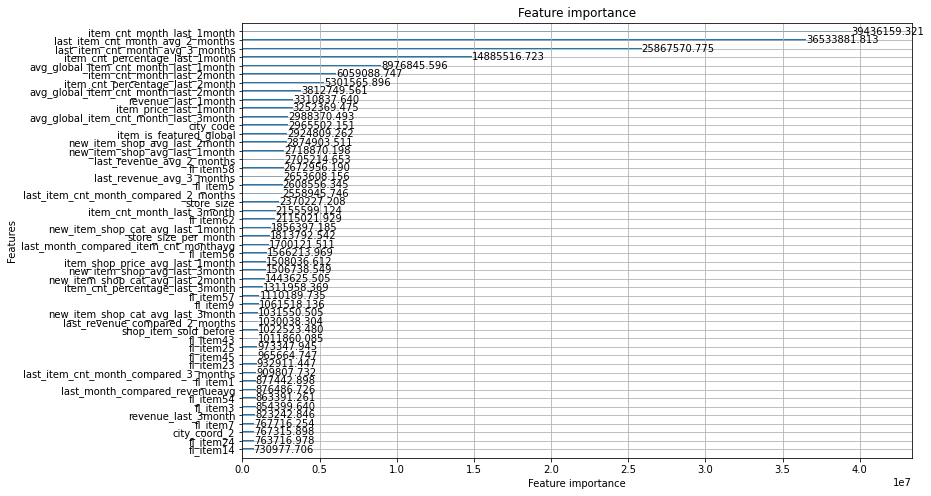

In [19]:
lgbm.plot_importance(
    best_lgbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8))

## Trying to overfit our model

In [21]:
params={'min_child_samples': 30,
       'learning_rate':0.005,
        'num_leaves': 50,
        'reg_lambda': 5,
        'min_split_gain': 10,
        'max_bin': 300
       } 
#del(best_lgbm)
best_lgbm = lgb_modelfit_nocv(params, x_train[pred+['item_cnt_month']], x_test[pred+['item_cnt_month']], predictors=pred, 
                              target='item_cnt_month', objective='mse', metrics='rmse',categorical_features=categorical)

preparing validation datasets


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[10]	train's rmse: 1.16632	valid's rmse: 1.12743
[20]	train's rmse: 1.14555	valid's rmse: 1.11032
[30]	train's rmse: 1.12679	valid's rmse: 1.0955
[40]	train's rmse: 1.10919	valid's rmse: 1.08182
[50]	train's rmse: 1.09266	valid's rmse: 1.06898
[60]	train's rmse: 1.077	valid's rmse: 1.05667
[70]	train's rmse: 1.06231	valid's rmse: 1.0451
[80]	train's rmse: 1.04899	valid's rmse: 1.0345
[90]	train's rmse: 1.03581	valid's rmse: 1.02431
[100]	train's rmse: 1.02371	valid's rmse: 1.01478
[110]	train's rmse: 1.01285	valid's rmse: 1.00632
[120]	train's rmse: 1.00286	valid's rmse: 0.998532
[130]	train's rmse: 0.993327	valid's rmse: 0.991239
[140]	train's rmse: 0.984596	valid's rmse: 0.984441
[150]	train's rmse: 0.976392	valid's rmse: 0.978119
[160]	train's rmse: 0.969066	valid's rmse: 0.972286
[170]	train's rmse: 0.961908	valid's rmse: 0.966705
[180]	train's rmse: 0.955641	valid's rmse: 0.961777
[190]	train's rmse: 0.949553	valid's rms

[1580]	train's rmse: 0.815018	valid's rmse: 0.868202
[1590]	train's rmse: 0.814772	valid's rmse: 0.868128
[1600]	train's rmse: 0.814502	valid's rmse: 0.868063
[1610]	train's rmse: 0.81424	valid's rmse: 0.867947
[1620]	train's rmse: 0.814045	valid's rmse: 0.867854
[1630]	train's rmse: 0.813825	valid's rmse: 0.867791
[1640]	train's rmse: 0.813568	valid's rmse: 0.867677
[1650]	train's rmse: 0.813372	valid's rmse: 0.86763
[1660]	train's rmse: 0.813113	valid's rmse: 0.867521
[1670]	train's rmse: 0.81284	valid's rmse: 0.867432
[1680]	train's rmse: 0.81257	valid's rmse: 0.867298
[1690]	train's rmse: 0.812314	valid's rmse: 0.867178
[1700]	train's rmse: 0.81209	valid's rmse: 0.86707
[1710]	train's rmse: 0.811839	valid's rmse: 0.86701
[1720]	train's rmse: 0.811572	valid's rmse: 0.866874
[1730]	train's rmse: 0.811318	valid's rmse: 0.866829
[1740]	train's rmse: 0.811094	valid's rmse: 0.866757
[1750]	train's rmse: 0.810891	valid's rmse: 0.866691
[1760]	train's rmse: 0.810659	valid's rmse: 0.866571


In [22]:
test['item_cnt_month']=best_lgbm.predict(test[pred])
test[['ID','item_cnt_month']].to_csv('submission_v51.csv',index_label='ID', index=False)

<ipython-input-22-44cbc7acab37>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_cnt_month']=best_lgbm.predict(test[pred])


### In this part we'll take advantage of a data leakage and try to fit our model only for the stores presented in the test final dataset!

In [23]:
params={
       'learning_rate': 0.005,
        'num_leaves': 50,
        'reg_lambda': 5,
        'min_split_gain': 10,
        'max_bin': 300,
        'feature_fraction': 0.75,
        'bagging_fraction': 0.75,
        'bagging_freq': 5
       } 

In [24]:
best_lgbm2 = lgb_modelfit_nocv(params, x_train[pred+['item_cnt_month']], x_test[pred+['item_cnt_month']], predictors=pred, 
                              target='item_cnt_month', objective='mse', metrics='rmse',categorical_features=categorical)
test['item_cnt_month']=best_lgbm2.predict(test[pred])
test[['ID','item_cnt_month']].to_csv('submission_v52.csv',index_label='ID', index=False)

preparing validation datasets
Training until validation scores don't improve for 50 rounds
[10]	train's rmse: 1.16301	valid's rmse: 1.12406
[20]	train's rmse: 1.13981	valid's rmse: 1.10463
[30]	train's rmse: 1.11845	valid's rmse: 1.08695
[40]	train's rmse: 1.0989	valid's rmse: 1.07114
[50]	train's rmse: 1.08054	valid's rmse: 1.05616
[60]	train's rmse: 1.06343	valid's rmse: 1.04226
[70]	train's rmse: 1.04777	valid's rmse: 1.02963
[80]	train's rmse: 1.03312	valid's rmse: 1.01797
[90]	train's rmse: 1.01958	valid's rmse: 1.00698
[100]	train's rmse: 1.00682	valid's rmse: 0.996839
[110]	train's rmse: 0.995278	valid's rmse: 0.987735
[120]	train's rmse: 0.984585	valid's rmse: 0.97938
[130]	train's rmse: 0.97454	valid's rmse: 0.971455
[140]	train's rmse: 0.965541	valid's rmse: 0.964396
[150]	train's rmse: 0.956681	valid's rmse: 0.957526
[160]	train's rmse: 0.94864	valid's rmse: 0.951236
[170]	train's rmse: 0.941229	valid's rmse: 0.945468
[180]	train's rmse: 0.934397	valid's rmse: 0.940142
[190]

[1580]	train's rmse: 0.800608	valid's rmse: 0.858318
[1590]	train's rmse: 0.800437	valid's rmse: 0.858284
[1600]	train's rmse: 0.800263	valid's rmse: 0.858198
[1610]	train's rmse: 0.800094	valid's rmse: 0.858141
[1620]	train's rmse: 0.799909	valid's rmse: 0.858078
[1630]	train's rmse: 0.799681	valid's rmse: 0.857974
[1640]	train's rmse: 0.799476	valid's rmse: 0.857936
[1650]	train's rmse: 0.799247	valid's rmse: 0.857849
[1660]	train's rmse: 0.799056	valid's rmse: 0.857822
[1670]	train's rmse: 0.798871	valid's rmse: 0.857802
[1680]	train's rmse: 0.798667	valid's rmse: 0.857674
[1690]	train's rmse: 0.798457	valid's rmse: 0.857623
[1700]	train's rmse: 0.798278	valid's rmse: 0.857554
[1710]	train's rmse: 0.7981	valid's rmse: 0.85748
[1720]	train's rmse: 0.797942	valid's rmse: 0.85748
[1730]	train's rmse: 0.797772	valid's rmse: 0.857435
[1740]	train's rmse: 0.797622	valid's rmse: 0.857404
[1750]	train's rmse: 0.797475	valid's rmse: 0.857387
[1760]	train's rmse: 0.797321	valid's rmse: 0.8573

<ipython-input-24-c6b64ef78d6d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_cnt_month']=best_lgbm2.predict(test[pred])


In [25]:
params={
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
       } 
#del(best_lgbm)
best_lgbm = lgb_modelfit_nocv(params, x_train[pred+['item_cnt_month']], x_test[pred+['item_cnt_month']], predictors=pred, 
                              target='item_cnt_month', objective='mse', metrics='rmse',categorical_features=categorical)
test['item_cnt_month']=best_lgbm2.predict(test[pred])
test[['ID','item_cnt_month']].to_csv('submission_v52.csv',index_label='ID', index=False)

preparing validation datasets
Training until validation scores don't improve for 50 rounds
[10]	train's rmse: 1.16183	valid's rmse: 1.12297
[20]	train's rmse: 1.13723	valid's rmse: 1.10207
[30]	train's rmse: 1.11423	valid's rmse: 1.08295
[40]	train's rmse: 1.09311	valid's rmse: 1.0655
[50]	train's rmse: 1.07348	valid's rmse: 1.04942
[60]	train's rmse: 1.05497	valid's rmse: 1.03402
[70]	train's rmse: 1.03806	valid's rmse: 1.02036
[80]	train's rmse: 1.02196	valid's rmse: 1.00749
[90]	train's rmse: 1.00718	valid's rmse: 0.995559
[100]	train's rmse: 0.993731	valid's rmse: 0.985092
[110]	train's rmse: 0.981119	valid's rmse: 0.975135
[120]	train's rmse: 0.969475	valid's rmse: 0.966115
[130]	train's rmse: 0.958694	valid's rmse: 0.95779
[140]	train's rmse: 0.948676	valid's rmse: 0.950308
[150]	train's rmse: 0.939332	valid's rmse: 0.943069
[160]	train's rmse: 0.930787	valid's rmse: 0.936563
[170]	train's rmse: 0.922798	valid's rmse: 0.930472
[180]	train's rmse: 0.915458	valid's rmse: 0.925117
[

[1570]	train's rmse: 0.766772	valid's rmse: 0.852938
[1580]	train's rmse: 0.766555	valid's rmse: 0.852923
[1590]	train's rmse: 0.766226	valid's rmse: 0.852882
[1600]	train's rmse: 0.765947	valid's rmse: 0.852861
[1610]	train's rmse: 0.765686	valid's rmse: 0.85285
[1620]	train's rmse: 0.765432	valid's rmse: 0.852843
[1630]	train's rmse: 0.765147	valid's rmse: 0.852856
[1640]	train's rmse: 0.764873	valid's rmse: 0.852813
[1650]	train's rmse: 0.764649	valid's rmse: 0.852735
[1660]	train's rmse: 0.764401	valid's rmse: 0.85264
[1670]	train's rmse: 0.764197	valid's rmse: 0.85259
[1680]	train's rmse: 0.763983	valid's rmse: 0.852593
[1690]	train's rmse: 0.76378	valid's rmse: 0.852572
[1700]	train's rmse: 0.763541	valid's rmse: 0.85254
[1710]	train's rmse: 0.763332	valid's rmse: 0.8525
[1720]	train's rmse: 0.763097	valid's rmse: 0.852448
[1730]	train's rmse: 0.762848	valid's rmse: 0.852426
[1740]	train's rmse: 0.762623	valid's rmse: 0.852362
[1750]	train's rmse: 0.762412	valid's rmse: 0.852333


<ipython-input-25-dfed386f31e3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_cnt_month']=best_lgbm2.predict(test[pred])


In [26]:
#44 1.210147 and 1.194534

In [ ]:
x_test[x_test.shop_id.isin(test.shop_id.unique())]

In [28]:
params={
    'min_child_samples': 30,
       'learning_rate':0.005,
        'num_leaves': 50,
        'reg_lambda': 5,
        'min_split_gain': 10,
        'max_bin': 300
       } 
best_lgbm = lgb_modelfit_nocv(params, x_train[x_train.shop_id.isin(test.shop_id.unique())][pred+['item_cnt_month']], x_test[x_test.shop_id.isin(test.shop_id.unique())][pred+['item_cnt_month']], predictors=pred, 
                              target='item_cnt_month', objective='mse', metrics='rmse',categorical_features=categorical, num_boost_round=3000)
test['item_cnt_month']=best_lgbm.predict(test[pred])
test[['ID','item_cnt_month']].to_csv('submission_v53.csv',index_label='ID', index=False)

preparing validation datasets
Training until validation scores don't improve for 50 rounds
[10]	train's rmse: 1.15447	valid's rmse: 1.10269
[20]	train's rmse: 1.13341	valid's rmse: 1.08424
[30]	train's rmse: 1.11441	valid's rmse: 1.06826
[40]	train's rmse: 1.09657	valid's rmse: 1.05341
[50]	train's rmse: 1.07979	valid's rmse: 1.03952
[60]	train's rmse: 1.06389	valid's rmse: 1.02609
[70]	train's rmse: 1.04901	valid's rmse: 1.0135
[80]	train's rmse: 1.03551	valid's rmse: 1.0019
[90]	train's rmse: 1.02215	valid's rmse: 0.990775
[100]	train's rmse: 1.0099	valid's rmse: 0.980392
[110]	train's rmse: 0.998885	valid's rmse: 0.971149
[120]	train's rmse: 0.988727	valid's rmse: 0.962566
[130]	train's rmse: 0.979044	valid's rmse: 0.954555
[140]	train's rmse: 0.970187	valid's rmse: 0.947121
[150]	train's rmse: 0.961849	valid's rmse: 0.940182
[160]	train's rmse: 0.954423	valid's rmse: 0.933826
[170]	train's rmse: 0.947134	valid's rmse: 0.927641
[180]	train's rmse: 0.940774	valid's rmse: 0.922191
[19

[1570]	train's rmse: 0.798481	valid's rmse: 0.817023
[1580]	train's rmse: 0.798198	valid's rmse: 0.816853
[1590]	train's rmse: 0.797942	valid's rmse: 0.816801
[1600]	train's rmse: 0.797688	valid's rmse: 0.816735
[1610]	train's rmse: 0.797427	valid's rmse: 0.816612
[1620]	train's rmse: 0.797223	valid's rmse: 0.816477
[1630]	train's rmse: 0.796997	valid's rmse: 0.816425
[1640]	train's rmse: 0.796735	valid's rmse: 0.816319
[1650]	train's rmse: 0.79653	valid's rmse: 0.816242
[1660]	train's rmse: 0.796265	valid's rmse: 0.816137
[1670]	train's rmse: 0.795987	valid's rmse: 0.816037
[1680]	train's rmse: 0.795713	valid's rmse: 0.815917
[1690]	train's rmse: 0.795458	valid's rmse: 0.815783
[1700]	train's rmse: 0.795216	valid's rmse: 0.815648
[1710]	train's rmse: 0.794958	valid's rmse: 0.815547
[1720]	train's rmse: 0.794685	valid's rmse: 0.815423
[1730]	train's rmse: 0.794425	valid's rmse: 0.815359
[1740]	train's rmse: 0.794223	valid's rmse: 0.815293
[1750]	train's rmse: 0.794016	valid's rmse: 0.8

<ipython-input-28-22769b29c28e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_cnt_month']=best_lgbm.predict(test[pred])
